## Code for data exploration, cleaning and
This code uses the pre processed datasets with the lemmarization and stopword removal.


Because each DataFrame was large, we applied this code sequentially, processing one dataset at a time rather than running it on all datasets simultaneously.

In [1]:
import pandas as pd
import os


In [2]:
df = pd.read_csv(r'C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\extrovert_introvert_preprocessed.csv') # this is the only line that needs change to process and clean a different dataset

In [3]:
df.shape

(40452, 6)

In [4]:
df.head()


,auhtor_ID,post,extrovert,text_raw,text_stopword,text_lemma
0,t2_2hrxxs28,"I have a question, if you have no doctor, how'...",0,"i have a question, if you have no doctor, how'...","question , doctor , painkillers ? otc painkill...","I have a question , if you have no doctor , ho..."
1,t2_2hrxxs28,butt to have Covid + your cycle. I'm not sure ...,0,butt to have covid + your cycle. i'm not sure ...,butt covid + cycle . sure going read women cov...,butt to have covid + your cycle . I be not sur...
2,t2_2hrxxs28,through different doctors. My situation sucks ...,0,through different doctors. my situation sucks ...,different doctors . situation sucks relate peo...,through different doctor . my situation suck b...
3,t2_4pxpgwz,i thought it was about the pebbleyeet guy the ...,0,i thought it was about the pebbleyeet guy the ...,thought pebbleyeet guy autistic guy wants “ fi...,I think it be about the pebbleyeet guy the aut...
4,t2_4pxpgwz,…i always end up voting wrong even as crewmate...,0,…i always end up voting wrong even as crewmate...,… end voting wrong crewmate . hours ago got lo...,… I always end up vote wrong even as crewmate ...


In [5]:
#dropping the post column since its the same one as the text_raw column, only differnce text raw is processed in lowercasing
df = df.drop(columns=["post"])


In [6]:
# Checking how many nan values we have, also checking if the lemmatization and stopword removal created any nan values
df.isna().sum()

auhtor_ID        0
extrovert        0
text_raw         0
text_stopword    0
text_lemma       0
dtype: int64

In [7]:
# remove duplicates, even if only few
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

df = df.drop_duplicates()


Duplicate rows: 1


This shows that our processing of the post did not create any nan values.
We did the stemmatization and stopword removal first so we can see how well it worked during cleaning.

Now we will create some code to see how clean our dataset is, check for duplicates or any other possible porblems it can have that we need to solve before we start modeling

##### Run time note : this code took 6 minutes to run on my device.


In [10]:

# Check duplicate rows if the removal worked
print("\nNumber of duplicated rows:", df.duplicated().sum())

TEXT_COLS = ["text_raw", "text_stopword", "text_lemma"]

for col in TEXT_COLS:
    if col not in df.columns:
        print(f"\nColumn '{col}' not found — skipped.")
        continue

    # Check empty or whitespace-only texts
    empty_texts = df[col].astype(str).str.strip().eq("").sum()
    print({col.upper()})
    print("Empty or whitespace-only texts:", empty_texts)

    # Check text length statistics
    text_lengths = df[col].astype(str).str.split().str.len()
    print("\nText length (number of tokens):")
    print(text_lengths.describe())

    # Extremely short texts
    print("Texts with < 3 tokens:", (text_lengths < 3).sum())



Number of duplicated rows: 0
{'TEXT_RAW'}
Empty or whitespace-only texts: 0

Text length (number of tokens):
count    40451.000000
mean      1474.421374
std        143.242476
min        268.000000
25%       1500.000000
50%       1500.000000
75%       1500.000000
max       1500.000000
Name: text_raw, dtype: float64
Texts with < 3 tokens: 0
{'TEXT_STOPWORD'}
Empty or whitespace-only texts: 0

Text length (number of tokens):
count    40451.000000
mean       881.043287
std        202.321197
min        127.000000
25%        794.000000
50%        857.000000
75%        929.000000
max      10306.000000
Name: text_stopword, dtype: float64
Texts with < 3 tokens: 0
{'TEXT_LEMMA'}
Empty or whitespace-only texts: 0

Text length (number of tokens):
count    40451.000000
mean      1746.043089
std        207.434734
min        303.000000
25%       1723.000000
50%       1762.000000
75%       1802.000000
max      11047.000000
Name: text_lemma, dtype: float64
Texts with < 3 tokens: 0


Another indication that our sematic removal code worked, was that for stopword removal code, the mean text length goes down from to  1474 ->881.
Also for lemmatization, dont will become do not, so thats why the mean lenght increased from 1474 -> 1746


In the normal dataset we can see that the texts are maybe capped to 1500 tokens length, with the 25 percentile being equal to the max. Therefore the distribution is very centered around 1500. Obviously for the other columns these numbers are different.

In [11]:
# checking min and max of each column and how many unqiue lenghts
for col in TEXT_COLS:
    lengths = df[col].astype(str).str.split().str.len()
    print(col, "nunique:", lengths.nunique(), "min:", lengths.min(), "max:", lengths.max())


text_raw nunique: 907 min: 268 max: 1500
text_stopword nunique: 1631 min: 127 max: 10306
text_lemma nunique: 1669 min: 303 max: 11047


## Visualizations

C:\Users\irene\AppData\Local\Temp\ipykernel_15964\3325314573.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(lengths_by_col, labels=labels, showfliers=True, whis=(5, 95))


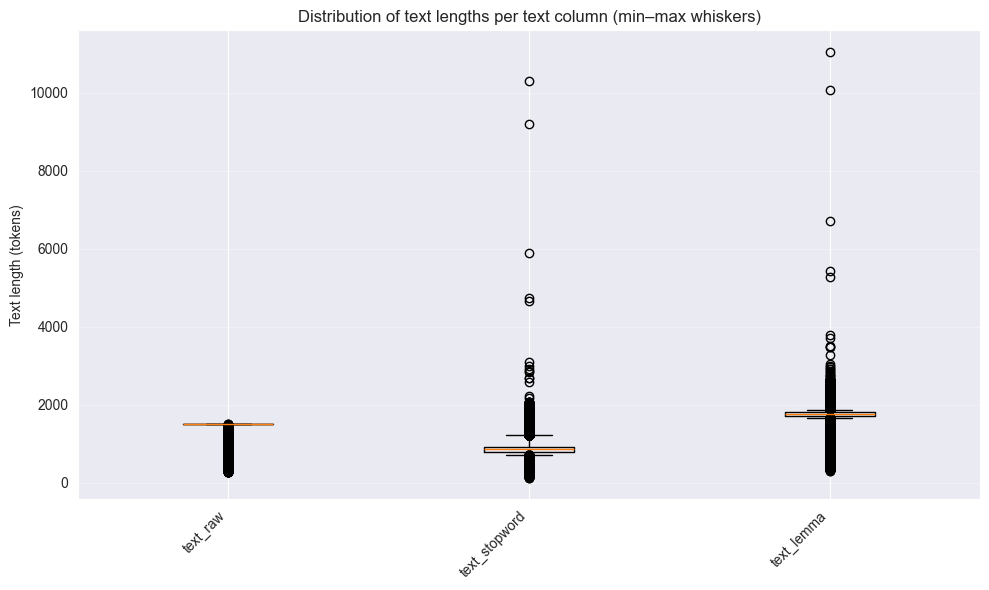

In [12]:
import matplotlib.pyplot as plt

lengths_by_col = []
labels = []

for col in TEXT_COLS:
    if col not in df.columns:
        continue

    lengths = df[col].fillna("").astype(str).str.split().str.len()
    lengths = lengths[lengths > 0]  # keep only non-empty texts

    lengths_by_col.append(lengths.values)
    labels.append(col)

plt.figure(figsize=(max(10, 0.55 * len(labels)), 6))

# whis=(0,100) makes whiskers go to min/max
plt.boxplot(lengths_by_col, labels=labels, showfliers=True, whis=(5, 95))

plt.xticks(rotation=45, ha="right")
plt.ylabel("Text length (tokens)")
plt.title("Distribution of text lengths per text column (min–max whiskers)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


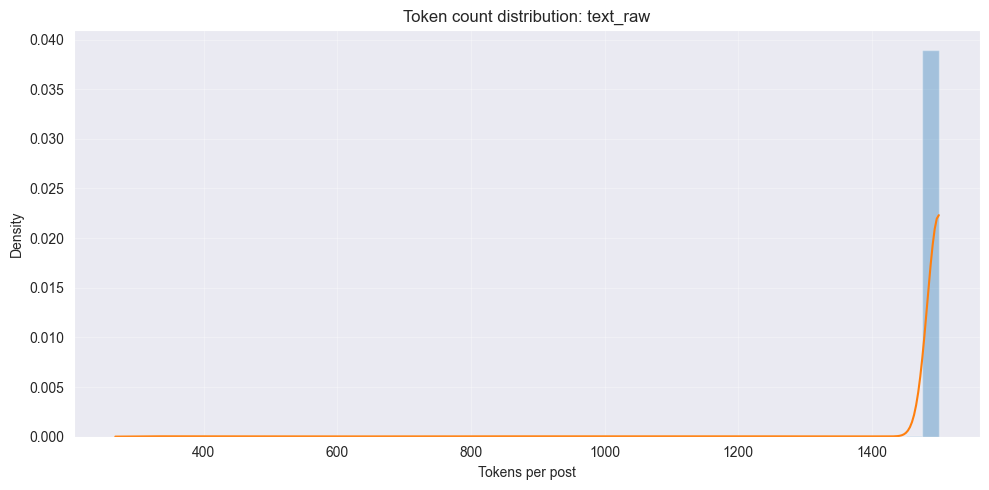

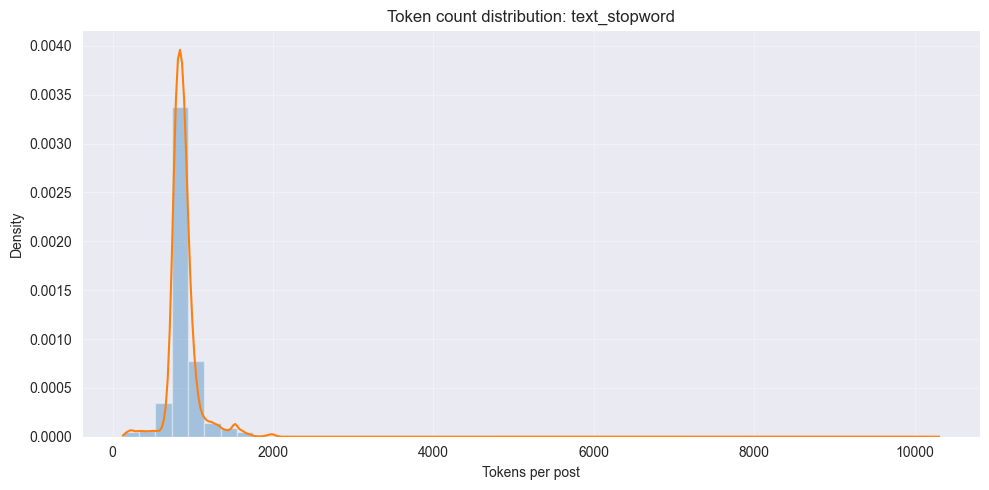

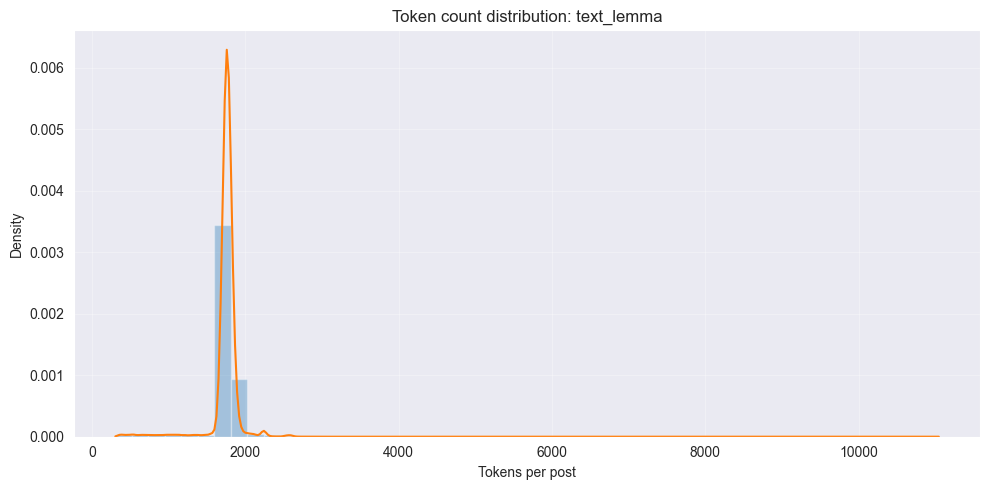

In [13]:
from scipy.stats import gaussian_kde
import numpy as np

MAX_TOKENS = None

for col in TEXT_COLS:
    lengths = df[col].fillna("").astype(str).str.split().str.len()
    lengths = lengths[lengths > 0]

    if MAX_TOKENS is not None:
        lengths = lengths[lengths <= MAX_TOKENS]

    x = lengths.to_numpy()

    plt.figure(figsize=(10, 5))
    plt.hist(x, bins=50, density=True, alpha=0.35)

    kde = gaussian_kde(x)
    grid = np.linspace(x.min(), x.max(), 400)
    plt.plot(grid, kde(grid))

    plt.title(f"Token count distribution: {col}")
    plt.xlabel("Tokens per post")
    plt.ylabel("Density")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [14]:
col = "text_lemma"
lengths = df[col].fillna("").astype(str).str.split().str.len()

print(">=2000:", (lengths >= 2000).sum())
print(">=5000:", (lengths >= 5000).sum())
print(">=10000:", (lengths >= 10000).sum())
#check for the outliers

>=2000: 844
>=5000: 5
>=10000: 2


In [15]:
col = "text_stopword"
lengths = df[col].fillna("").astype(str).str.split().str.len()

print(">=2000:", (lengths >= 2000).sum())
print(">=5000:", (lengths >= 5000).sum())
print(">=10000:", (lengths >= 10000).sum())
#check for the outliers

>=2000: 56
>=5000: 3
>=10000: 1


A small number of preprocessed texts exceed the 1500-token cap of the post column. This happens because we rebuild text from spaCy tokens while keeping punctuation (KEEP_PUNCTUATION=True): for noisy posts with many symbols/URLs/markup, spaCy splits punctuation into separate tokens (e.g., !!! → ! ! !), which inflates token counts even after stopword removal.

We chose not to delete these rows. Instead, we truncate all text columns to a fixed maximum length so extreme cases do not dominate plots or training. While truncation can remove some information, it affects only a small fraction of rows and the cap is above the typical text length, so the impact on modeling is minimal.

In [17]:
CAP = 2000
for col in ["text_raw", "text_stopword", "text_lemma"]:
    df[col] = df[col].fillna("").astype(str).str.split().str[:CAP].str.join(" ")


Based on the code results, we see that dataset is generally clean, we will remove the duplicate rows to avoid uneccesary noise.


In [21]:
print(TEXT_COLS)

['post', 'text_stopword', 'text_lemma']


Mean tokens per text column:
text_lemma       1740.195694
text_raw         1474.421374
text_stopword     880.231070
dtype: float64


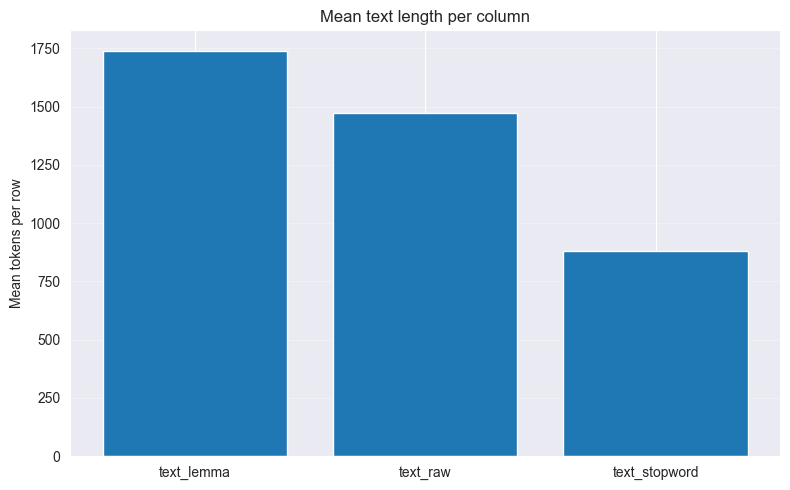

C:\Users\irene\AppData\Local\Temp\ipykernel_15964\442892305.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True, whis=(5, 95))  # percentile whiskers


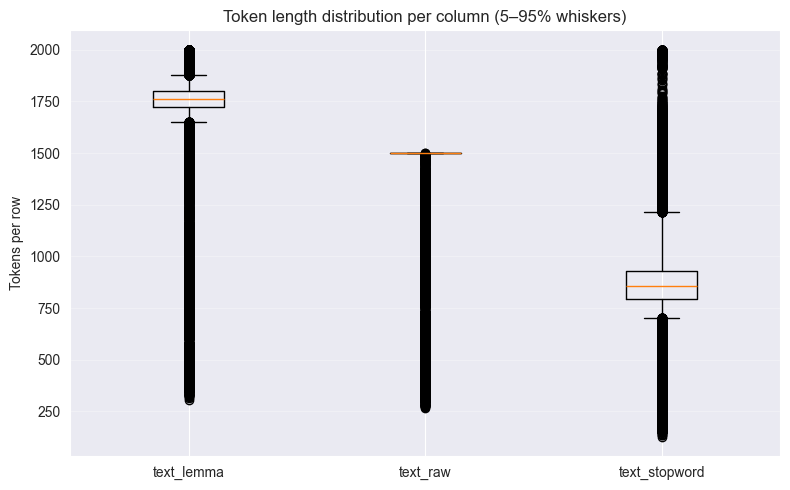

In [22]:

TEXT_COLS = ["text_raw", "text_stopword", "text_lemma"]
MAX_TOKENS = None

lengths_dict = {}
means = {}

for col in TEXT_COLS:
    lengths = df[col].fillna("").astype(str).str.split().str.len()
    lengths = lengths[lengths > 0]  # ignore empty texts
    if MAX_TOKENS is not None:
        lengths = lengths[lengths <= MAX_TOKENS]

    lengths_dict[col] = lengths
    means[col] = lengths.mean()

means_series = pd.Series(means).sort_index()
print("Mean tokens per text column:")
print(means_series)

#Plot 1: Bar chart of means ---
plt.figure(figsize=(8, 5))
plt.bar(means_series.index, means_series.values)
plt.ylabel("Mean tokens per row")
plt.title("Mean text length per column")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Boxplot of distributions (more informative than means)
data = [lengths_dict[col].values for col in means_series.index]
labels = list(means_series.index)

plt.figure(figsize=(8, 5))
plt.boxplot(data, labels=labels, showfliers=True, whis=(5, 95))  # percentile whiskers
plt.ylabel("Tokens per row")
plt.title("Token length distribution per column (5–95% whiskers)")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


And now we start with the label/ balancing cleaning

In [22]:
text_col = "raw_text"
label_col = "extrovert"

# Label inspection
print("\nUnique labels:")
print(df[label_col].unique())

print("\nLabel distribution:")
print(df[label_col].value_counts())

print("\nLabel distribution (normalized):")
print(df[label_col].value_counts(normalize=True))

# Same text with multiple labels
multi_label_texts = (
    df.groupby(text_col)[label_col]
      .nunique()
      .gt(1)
      .sum()
)
print("\nTexts appearing with multiple labels:", multi_label_texts)



Unique labels:
[0 1]

Label distribution:
extrovert
0    31370
1     9081
Name: count, dtype: int64

Label distribution (normalized):
extrovert
0    0.775506
1    0.224494
Name: proportion, dtype: float64

Texts appearing with multiple labels: 0


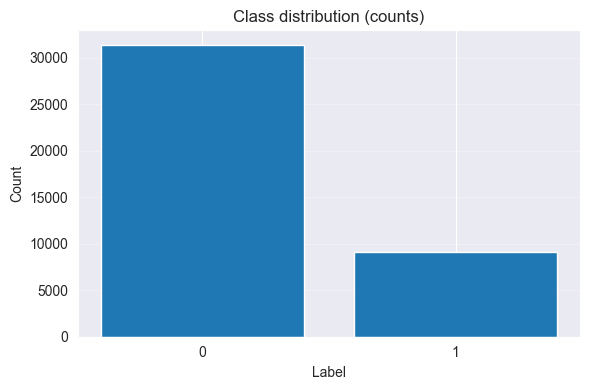

In [23]:

label_col = "extrovert"
counts = df[label_col].value_counts().sort_index()

plt.figure(figsize=(6, 4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Class distribution (counts)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


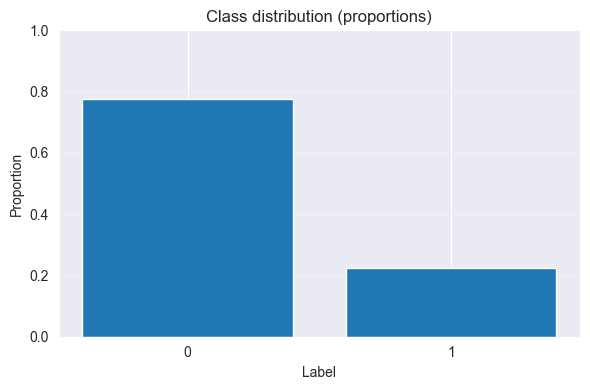

In [24]:

props = df[label_col].value_counts(normalize=True).sort_index()

plt.figure(figsize=(6, 4))
plt.bar(props.index.astype(str), props.values)
plt.title("Class distribution (proportions)")
plt.xlabel("Label")
plt.ylabel("Proportion")
plt.ylim(0, 1)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


There is a clear unbalance in the dataset, with some of the classes being more prevalent to others. For no possibility of data leakage, we will split the datasets first, and then balance each one.

Splitting on author is mandatory in our case, since we would not want an author that is in the train set to be in the test set as well.

In [25]:
AUTHOR_COL = "auhtor_ID"

n_rows = len(df)
n_authors = df[AUTHOR_COL].nunique(dropna=True)
posts_per_author = n_rows / n_authors if n_authors > 0 else float("nan")

print(f"unique authors = {n_authors:,} | rows = {n_rows:,} | avg posts/author = {posts_per_author:.2f}")


unique authors = 1,992 | rows = 40,451 | avg posts/author = 20.31


Now we split the data

In [26]:
from sklearn.model_selection import train_test_split

def split_by_author_train_test(df, author_col, test_size=0.2, seed=42):
    authors = df[author_col].dropna().unique()

    train_authors, test_authors = train_test_split(
        authors, test_size=test_size, random_state=seed
    )

    train_df = df[df[author_col].isin(train_authors)].copy()
    test_df  = df[df[author_col].isin(test_authors)].copy()

    return {"train": train_df, "test": test_df}


In [27]:
splits = split_by_author_train_test(df, author_col="auhtor_ID", test_size=0.2, seed=42)
train_df = splits["train"]
test_df = splits["test"]


In [28]:

splits = split_by_author_train_test(df, author_col=AUTHOR_COL, test_size=0.2, seed=42)

print("train:", len(splits["train"]), "test:", len(splits["test"]))


train: 31254 test: 9197


See distribution in splits :


In [29]:
LABEL_COL = "extrovert"

print("\nEXTROVERT")

for split_name, split_df in splits.items():
    print(f"\n{split_name.upper()} label distribution (counts):")
    print(split_df[LABEL_COL].value_counts())

    print(f"{split_name.upper()} label distribution (normalized):")
    print(split_df[LABEL_COL].value_counts(normalize=True).round(4))



EXTROVERT

TRAIN label distribution (counts):
extrovert
0    24215
1     7039
Name: count, dtype: int64
TRAIN label distribution (normalized):
extrovert
0    0.7748
1    0.2252
Name: proportion, dtype: float64

TEST label distribution (counts):
extrovert
0    7155
1    2042
Name: count, dtype: int64
TEST label distribution (normalized):
extrovert
0    0.778
1    0.222
Name: proportion, dtype: float64


### Class balancing
After considering the 4 options from the tutorials, to balance the data we decided to go with stratified sampling.
We will only be balancing the train splits, test and validation spltis should be left untouched

In [30]:
# code to save the train and test df into a csv
OUTPUT_DIR = r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\final_data"
os.makedirs(OUTPUT_DIR, exist_ok=True)

for split_name, split_df in splits.items():
    filename = f"extrovert_{split_name}.csv"
    path = os.path.join(OUTPUT_DIR, filename)
    split_df.to_csv(path, index=False)


Ideally we will do stratified sampling,however we turned into a problem trying to implement it in the DeliBert model. Therefore, so that there is no difference between the datasets of the models are training on, we will be doing undersampling of the majority class. Doing a 50-50 balancing ratio is too extreme and would potentially hurt our models performance. therefore we will introduce a function to do it with a ratio. A good number would be 0.7

In [31]:
def undersample_with_ratio(df, label_col, target_ratio=0.65, random_state=42):
    counts = df[label_col].value_counts()
    minority_class = counts.idxmin()
    majority_class = counts.idxmax()

    n_min = counts[minority_class]
    n_maj_target = int(n_min / (1 - target_ratio))

    df_min = df[df[label_col] == minority_class]
    df_maj = df[df[label_col] == majority_class].sample(
        n=min(n_maj_target, counts[majority_class]),
        random_state=random_state
    )

    return pd.concat([df_min, df_maj]).sample(
        frac=1,
        random_state=random_state
    ).reset_index(drop=True)


In [32]:


INPUT_TRAIN = r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\final_data\extrovert_train.csv"
OUT_DIR = r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\balanced_train"
os.makedirs(OUT_DIR, exist_ok=True)

LABEL_COL = "extrovert"

train_df = pd.read_csv(INPUT_TRAIN)

balanced_train_df = undersample_with_ratio(train_df, LABEL_COL)

out_path = os.path.join(OUT_DIR, "balanced_extrovert_train.csv")
balanced_train_df.to_csv(out_path, index=False)

print(balanced_train_df[LABEL_COL].value_counts())


extrovert
0    20111
1     7039
Name: count, dtype: int64


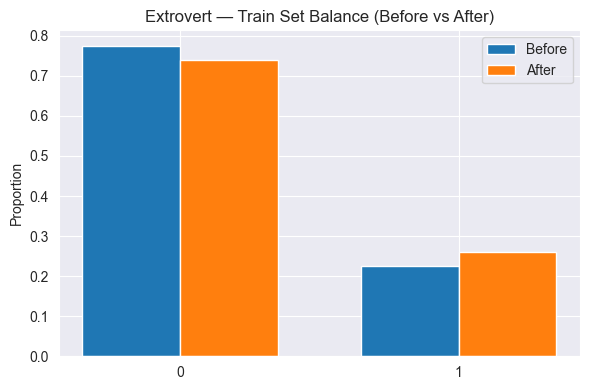

In [33]:
# code that loads new column distribution and plots
def load_distribution(path, label_col):
    df = pd.read_csv(path)
    return df[label_col].value_counts(normalize=True).sort_index()

LABEL_COL = "extrovert"

original_path = r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\final_data\extrovert_train.csv"
balanced_path = r"C:\Users\irene\OneDrive\Υπολογιστής\Magdaskkkrtt\Language-and-AI\processed data\balanced_train\balanced_extrovert_train.csv"

before = load_distribution(original_path, LABEL_COL)
after  = load_distribution(balanced_path, LABEL_COL)

labels = sorted(set(before.index).union(set(after.index)))
before_vals = [before.get(l, 0) for l in labels]
after_vals  = [after.get(l, 0) for l in labels]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, before_vals, width, label="Before")
plt.bar(x + width/2, after_vals,  width, label="After")

plt.xticks(x, labels)
plt.ylabel("Proportion")
plt.title("Extrovert — Train Set Balance (Before vs After)")
plt.legend()
plt.tight_layout()
plt.show()


We see that the difference is not that big, however putting the ration higher e.g. 0.6 we would throw away data for a small gain.
This way we ensure that our data is not extremely unbalanced, 80 for majority.